Firstly I want to clean and transform the dataset into a format that I can easily train and evaluate my models on. <br>
Loading in and visualising the data is the first step.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

df = pd.read_csv('data.csv')
print(df.shape)

(50000, 60)


In [2]:
for col in df:
    print('-----------------')
    print(f'feature: {col}')
    print(df[col].value_counts())
    print('-----------------')

-----------------
feature: candidate_id
bgjikcrozdgkrtzigymnaylpypxxublc0        1
ofacorucqeodmhwxbrwfwjqsdaafyvky33350    1
cqvmqnymmdwptstkmujnneseoiqbwrne33328    1
jpiizgnklifjbrntontjpfohwcnwoekl33329    1
zdgybcguficcdfzlpstluhziokcsxswp33330    1
                                        ..
ltxvztomcjuwkgbgukceqgkjkyfpgytt16668    1
qmjtskergapokdedcmjgrphzrfmbhemw16669    1
muasztjtujpgnvkodjtqleglqtxububr16670    1
ppvtjjahslsxywbseiyrtkcxngsxxits16671    1
kifewbinvomrspttqkjbbqasqlglkysu49999    1
Name: candidate_id, Length: 50000, dtype: int64
-----------------
-----------------
feature: application_status
pre-interview    20350
hired            15122
interview        14528
Name: application_status, dtype: int64
-----------------
-----------------
feature: number_of_employees_log
4.0    18169
2.9     9902
2.0     9009
2.6     8572
1.0     4348
Name: number_of_employees_log, dtype: int64
-----------------
-----------------
feature: occupation_id
exvwhbxlejsfyqxnwjabksnntpwodf

This should help me to identify the nature of the features in the dataset, including which ones will be useful for making predictions and which values would be sensible to fill in for missing entries.

It is worth highlighting that the candidate, occupation and company ids are all unique for each row, so each entry is independent. These values won't offer any predictive power and can be discarded.

occupation_skill_counts are all binary variables, so it would be sensible to assume that a missing value would be indicative of 0 (missing this skill).

candidate_attribute_1 is another binary variable, in this case it is not so clear how to deal with so will exclude (could predict?).

candidate attribute_2 is a floating point value, not much choice but to use an average to replace missing values. Could be more granular using other data to predict with more time.

application_attribute_1 is all unique values, so discard.

candidate_demographic_variables 1-4 are all binary, another case of hard to replace missing values. Could consider excluding these features, with more time could predict more sensible values within certain group demographics using the other data.

In the case of ethnicity we can reasonably fill missing values as 'Rather not say'.

candidate_demographic_variable 5 is another hard to fill column, will likely exclude.

6-8 are similar ^, 9 & 10 no missing values.

Age as a floating point is a another case of using the average (could predict from other features with more time?)

candidate_attribute 3-5 are floats, so using the average to fill missing values makes sense (as before, could predict). Another approach could be to sample randomly from the empirical distribution as a source of randomness for the ensemble of models

discard 6&7, could predict etc.

candidate_interest: 1 & 3-8, use mean/sample/predict; 2, single valued (discard).

candidate_attribute_8: average/sample/predict

number_years_feature 1-5: will assume here that a blank indicates zero years (assuming this refers to experience)

candidate_skill_count 1-9: will again assume that missing value indicates a count of 0.

candidate_relative_test 1 & 2: average/sample/predict



In [3]:
features_to_remove = []

with open('discard_features.txt', 'r') as f:
    features_to_remove = f.read().splitlines()

print(features_to_remove)

trimmed_df = df.drop(columns=features_to_remove)

['candidate_id', 'occupation_id', 'company_id', 'candidate_attribute_1', 'application_attribute_1', 'candidate_demographic_variable_1', 'candidate_demographic_variable_2', 'candidate_demographic_variable_3', 'candidate_demographic_variable_4', 'candidate_demographic_variable_5', 'candidate_demographic_variable_6', 'candidate_demographic_variable_7', 'candidate_demographic_variable_8', 'candidate_attribute_6', 'candidate_attribute_7', 'candidate_interest_2']


In [4]:
features_to_zero = []

with open('zero_features.txt', 'r') as f:
    features_to_zero = f.read().splitlines()

print(features_to_zero)

for col in features_to_zero:
    trimmed_df[col] = trimmed_df[col].fillna(0)

['occupation_skill_1_count', 'occupation_skill_2_count', 'occupation_skill_3_count', 'occupation_skill_4_count', 'occupation_skill_5_count', 'occupation_skill_6_count', 'occupation_skill_7_count', 'occupation_skill_8_count', 'occupation_skill_9_count', 'number_years_feature_1', 'number_years_feature_2', 'number_years_feature_3', 'number_years_feature_4', 'number_years_feature_5', 'candidate_skill_1_count', 'candidate_skill_2_count', 'candidate_skill_3_count', 'candidate_skill_4_count', 'candidate_skill_5_count', 'candidate_skill_6_count', 'candidate_skill_7_count', 'candidate_skill_8_count', 'candidate_skill_9_count']


In [5]:
trimmed_df['ethnicity'] = trimmed_df['ethnicity'].fillna('Rather not say')

Need to encode the categorical variables (namely ethnicity, gender and application status (the target variable)), will use one-hot encoding here and remove a column (since the encodings are confounded variables).

In [6]:
trimmed_df['hired'] = trimmed_df['application_status'].replace(to_replace=['pre-interview', 'hired', 'interview'],
                                                                            value=[0, 1, 0])

ethnicity_list = pd.get_dummies(trimmed_df['ethnicity'], drop_first=True)
gender_list = pd.get_dummies(trimmed_df['gender'], drop_first=True)

encoded_df = pd.concat([trimmed_df, ethnicity_list, gender_list], axis=1)
encoded_df = encoded_df.drop(columns=['application_status', 'gender', 'ethnicity'])

In [7]:
features_to_average = []
median_df = encoded_df.copy(deep=True)
mean_df = encoded_df.copy(deep=True)

with open('average_features.txt', 'r') as f:
    features_to_average = f.read().splitlines()

print(features_to_average)

for col in features_to_average:
    median_df[col] = median_df[col].fillna(median_df[col].median())
    mean_df[col] = mean_df[col].fillna(mean_df[col].mean())

['candidate_attribute_2', 'candidate_attribute_3', 'candidate_attribute_4', 'candidate_attribute_5', 'candidate_attribute_8', 'age', 'candidate_interest_1', 'candidate_interest_3', 'candidate_interest_4', 'candidate_interest_5', 'candidate_interest_6', 'candidate_interest_7', 'candidate_interest_8', 'candidate_relative_test_1', 'candidate_relative_test_2']


In [11]:
# X_train, X_test, y_train, y_test = train_test_split(median_df.drop(columns=['hired']), median_df['hired'], test_size=0.2, random_state=11)
X_train, X_test, y_train, y_test = train_test_split(mean_df.drop(columns=['hired']), mean_df['hired'], test_size=0.2, random_state=11)

I have added class weights to the Logistic Regression model (without this the model was completely skewed in almost always predicting failure as this is the dominating class).

In [12]:
#imbalance in the data, could use class weights
model = LogisticRegression(max_iter=1500, class_weight={0:1, 1:2.33})
model.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 2.33}, max_iter=1500)

In [16]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

def eval_model(model, X, y_true):
    pred = model.predict(X_test)
    print(classification_report(y_test, pred))
    RocCurveDisplay.from_estimator(model, X, y_true)
    plt.show()


              precision    recall  f1-score   support

           0       0.74      0.59      0.66      6975
           1       0.36      0.53      0.43      3025

    accuracy                           0.57     10000
   macro avg       0.55      0.56      0.54     10000
weighted avg       0.63      0.57      0.59     10000

area under ROC curve: 0.559307443940875


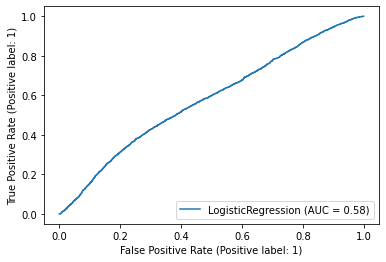

In [15]:

eval_model(model, X_test, y_test)

Neither the mean nor the median average models seem to be performing well, perhaps too many of the strongly predictive columns were discarded, or the zeroing of certain features was not appropriate. I will leave the model as is for the sake of the time and exploring the systemacity analysis.

I'm going to use the relatively simple approach of creating a stratified k-fold of the dataset to train k identicals models with similar accuracies. With more time, I would have liked to explore the possibility of training each model on the trimmed dataset and then sampling missing values from the column's empirical distribution for each model, and also an ensemble of models that made use of a random subset of features (perhaps with a select few highly predictive features always included).

In [ ]:
from sklearn.model_selection import StratifiedKFold

def create_ensemble(X, y, num_models=10):
    ensemble = []
    skf = StratifiedKFold(n_splits=num_models)

    for train_index, holdout_index in skf.split(X, y):
        print("TRAIN:", train_index, "HOLDOUT:", holdout_index)
        X_train = X[train_index]
        y_train = y[train_index]
        model = LogisticRegression(max_iter=1500, class_weight={0:1, 1:2.33})
        model.fit(X_train, y_train)
        ensemble.append(model)

    return ensemble

def predict(X, ensemble):
    index = np.random.choice(len(ensemble))
    return ensemble[index].predict(X)
